# Machine Learning: Classification 



In [6]:
%pylab inline
from ggplot import *

# Enable inline plotting


from sklearn.datasets import load_iris
import numpy as np
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [17]:
data = load_iris()
# The data has some meta data appended at the top of the file
# The data is stored in the array "data"
# The field names are stored in "feature_names"
# Acutal flower names are stored in "target"
col_names = data['feature_names']

df = pd.DataFrame(data['data'], columns = col_names)
# Add in the Iris Id data
df['Iris Flower'] = data['target']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 0 to 149
Data columns (total 5 columns):
sepal length (cm)    150 non-null float64
sepal width (cm)     150 non-null float64
petal length (cm)    150 non-null float64
petal width (cm)     150 non-null float64
Iris Flower          150 non-null int32
dtypes: float64(4), int32(1)
memory usage: 6.4 KB


Let's quickly re-name the **Iris flower** from an integer to the actual names as strings.

In [18]:
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Iris Flower
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [19]:
df['Iris Flower'][df['Iris Flower']== 0] = 'Setosa' 
df['Iris Flower'][df['Iris Flower']== 1] = 'Versicolor' 
df['Iris Flower'][df['Iris Flower']== 2] = 'Virginica' 
# Print unique names to test if it worked properly
print pd.unique(df["Iris Flower"])

['Setosa' 'Versicolor' 'Virginica']


/home/tobie/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Let's get a quick look at our data so far.

In [20]:
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Iris Flower
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


In [21]:
df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


It's always a good idea to start plotting early to get a deeper sense of the data.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0xa675106c>,
        <matplotlib.axes._subplots.AxesSubplot object at 0xa7bb71ac>]], dtype=object)

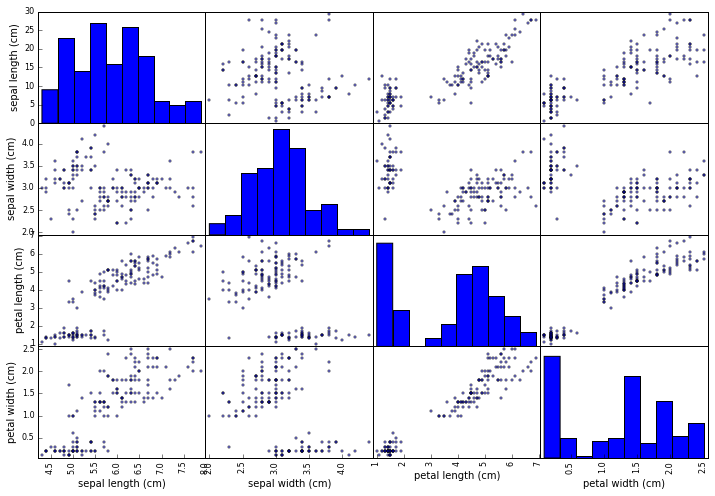

In [22]:
from pandas.tools.plotting import scatter_matrix

scatter_matrix(df, figsize=[12,8])

This looks alright, but really we want to see the different flowers as separate colors, which is not easily possible right now. I did however find a keen <a href = ""http://stackoverflow.com/users/1586229/bgschiller>"Stack Overflow user</a> who developed a custom version for now.

In [23]:
def factor_scatter_matrix(df, factor, palette=None):

    import matplotlib.colors
    from scipy.stats import gaussian_kde

    if isinstance(factor, basestring):
        factor_name = factor #save off the name
        factor = df[factor] #extract column
        df = df.drop(factor_name,axis=1) # remove from df, so it 
        # doesn't get a row and col in the plot.

    classes = list(set(factor))

    if palette is None:
        palette = ['#e41a1c', '#377eb8', '#4eae4b', 
                   '#994fa1', '#ff8101', '#fdfc33', 
                   '#a8572c', '#f482be', '#999999']

    color_map = dict(zip(classes,palette))

    if len(classes) > len(palette):
        raise ValueError('''Too many groups for the number of colors provided.
We only have {} colors in the palette, but you have {}
groups.'''.format(len(palette), len(classes)))

    colors = factor.apply(lambda group: color_map[group])
    axarr = scatter_matrix(df,figsize=(10,10),marker='o',c=colors,diagonal=None)


    for rc in xrange(len(df.columns)):
        for group in classes:
            y = df[factor == group].icol(rc).values
            gkde = gaussian_kde(y)
            ind = np.linspace(y.min(), y.max(), 1000)
            axarr[rc][rc].plot(ind, gkde.evaluate(ind),c=color_map[group])

    return axarr, color_map

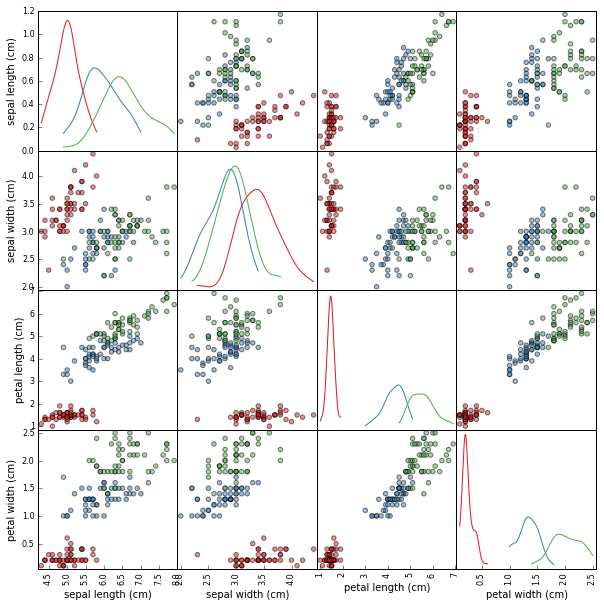

In [24]:
axarr, color_map = factor_scatter_matrix(df,'Iris Flower')

**ITS BEAUTIFUL**

On the subject of useful plotting methods, <a href = "http://stanford.edu/~mwaskom/software/seaborn/tutorial/axis_grids.html#plotting-bivariate-data-with-jointgrid"> Seaborn</a> is producing some really cool stuff. I find the scatterplot + histograms really useful.

Anyways, ggplot can at least take care of the rest of out plotting needs.

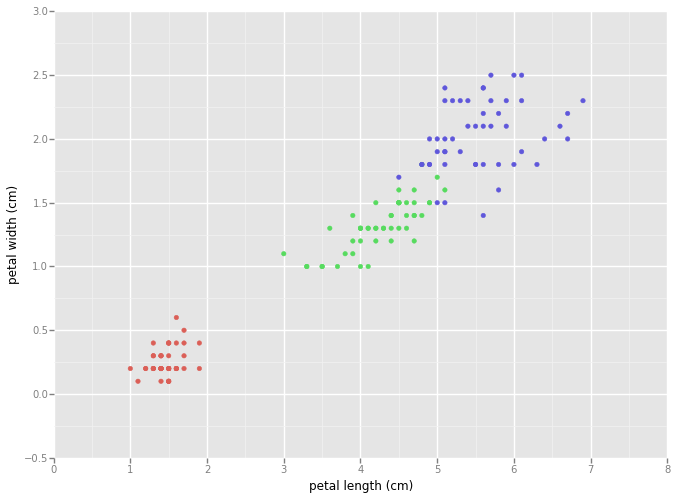

<ggplot: (-899657430)>


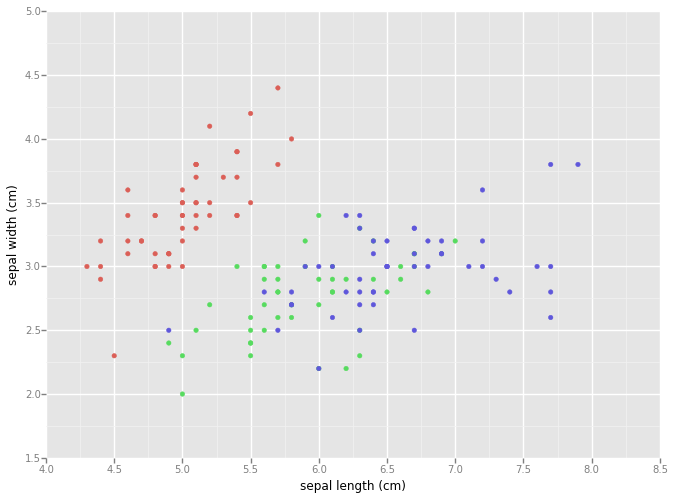

<ggplot: (-899787168)>


In [25]:
print(ggplot(df, aes(x="petal length (cm)",y="petal width (cm)", color = "Iris Flower"))+geom_point())
print(ggplot(df, aes(x="sepal length (cm)",y="sepal width (cm)", color = "Iris Flower"))+geom_point())

# The simplest way to classify

Our goal is to develop a model to classify the three different types of flowers. 

By inspecting the graphs above, we can see that there is actually a very clear separation in petal length and width between Iris Setosa and the other two flowers. 

We could write some quick code to classify that.

In [26]:
# Determine the cutoffs for Iris Setosa petal length
setosa = df['Iris Flower'] == "Setosa"

max_setosa = df['petal length (cm)'][setosa].max()
print "Setosa max petal length: {} cm".format(max_setosa)

# Find the minimum petal length for the other plants
min_not_setosa = df['petal length (cm)'][-setosa].min()
print "Not Setosa min petal length: {} cm".format(min_not_setosa)

Setosa max petal length: 1.9 cm
Not Setosa min petal length: 3.0 cm


Once we have this classification scheme, we can create a very simply model to identify the type of flower.

In [27]:
petal_length = df['petal length (cm)']
#Incoming wall of text
for flower in petal_length:
    if flower <= 1.9:
        print("Iris Setosa")
    else:
        print("Iris Virginica or Iris Versicolour")

Iris Setosa
Iris Setosa
Iris Setosa
Iris Setosa
Iris Setosa
Iris Setosa
Iris Setosa
Iris Setosa
Iris Setosa
Iris Setosa
Iris Setosa
Iris Setosa
Iris Setosa
Iris Setosa
Iris Setosa
Iris Setosa
Iris Setosa
Iris Setosa
Iris Setosa
Iris Setosa
Iris Setosa
Iris Setosa
Iris Setosa
Iris Setosa
Iris Setosa
Iris Setosa
Iris Setosa
Iris Setosa
Iris Setosa
Iris Setosa
Iris Setosa
Iris Setosa
Iris Setosa
Iris Setosa
Iris Setosa
Iris Setosa
Iris Setosa
Iris Setosa
Iris Setosa
Iris Setosa
Iris Setosa
Iris Setosa
Iris Setosa
Iris Setosa
Iris Setosa
Iris Setosa
Iris Setosa
Iris Setosa
Iris Setosa
Iris Setosa
Iris Virginica or Iris Versicolour
Iris Virginica or Iris Versicolour
Iris Virginica or Iris Versicolour
Iris Virginica or Iris Versicolour
Iris Virginica or Iris Versicolour
Iris Virginica or Iris Versicolour
Iris Virginica or Iris Versicolour
Iris Virginica or Iris Versicolour
Iris Virginica or Iris Versicolour
Iris Virginica or Iris Versicolour
Iris Virginica or Iris Versicolour
Iris Virginica 

<hr>
That was less than exciting. This was just a simple example of a **manually implemented dimension threshold**. Eventually, we will get some **machine learning** to do this for us.

We can see that we will never attain perfect separation between Iris Virginica and Iris Versicolour, since there is some degree of overlap between them.

However, we can still try to implement another threshold.

In [28]:
# First we select non-Setosa flowers
flowers = df[-setosa]

# Create a boolean mask of Iris Virginica to test prediction against
is_virginica = flowers['Iris Flower'] == 'Virginica'

# Convert to plain matrix for this simple looping operation
flowers = flowers.as_matrix()

Now we are going to loop through each of the petal and sepal features in the data and test each value as a potential threshold. At the same time we will keep track of the threshold with the best prediction accuracy.

In [29]:
best_accuracy = [0, 0, 0]  # accuracy, feature, threshold
# for each flower feature in the data (columns 1 - 4)
# sepal length (cm) = 0 	
# sepal width (cm) = 1	
# petal length (cm)	= 2
# petal width (cm) = 3
for feature in xrange(4):
     
    threshold = flowers[:,feature].copy()
    threshold.sort()
    
    # Now test all these values as thresholds
    for thresh in threshold:
        prediction = flowers[:,feature] > thresh
        accuracy = (prediction == is_virginica).mean()
        if accuracy > best_accuracy[0]:
            best_accuracy = [accuracy, feature, thresh]
print best_accuracy

[0.93999999999999995, 3, 1.6]


Great, we can see that we found our best flower classifying accuracy was 94% using petal width at 1.6 cm.

Lets see how this looks on a plot.

KeyError: 0L

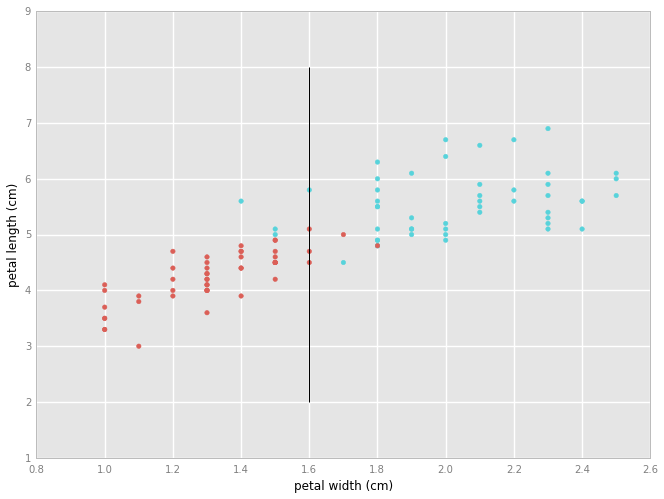

In [30]:
# Select non-Setosa flowers
flowers = df[-setosa]
ggplot(flowers, aes(x="petal width (cm)", y="petal length (cm)", \
                    color = "Iris Flower")) + \
geom_point() + \
geom_vline(xintercept = 1.6, color = "black")

Hey! Not bad. **BUT**

# Testing / Training data and Cross-Validation

Our previous model achieved 94% accuracy, however, this is likely over-estimated. We used the same data to both define the threshold, and then evaluate the model.

What we should be doing is generalize the power of our model on new instances of data. In other words, we will define the threshold on a **training set** of data, and evaluate the model on the **test set** of data that the model did not see in training.

It is therefore only appropriate to report training error, not testing error, when communicating your results.

For now, we will split the data in half to achieve this, though more consideration should be taken later, in more complex models. Sometimes the models can be sensitive to how much data we include in either set. For example: sometimes too little data for testing could skew the result.

To avoid this problem, it would be nice to somehow use all the data for both testing and training.

This is where **cross-validation** comes in. There are many types of cross validation, but the most extreme case is **leave-one-out**. Under this framework, if we have 100 points of data in our training set, we:

- remove *i* th element of the training set
- train model using the training set
- predict model with testing set, where testing = training - *i* th element
- record the error
- repeat until all *i* elements of training set have been omitted (one at a time)
- sum error

Generally, we don't use leave-one-out unless we need particularly high precision, as other techniques are sufficient for most cases. The biggest caveat of "leave-one-out" cross-validation is dramatic increases in computation speed, particularly as dataset become large.


You can read up on the other types of cross validation <a href = "http://en.wikipedia.org/wiki/Cross-validation_(statistics)">here</a>.

## Getting a feel for testing and training data

Using pandas, we can efficiently split the data into testing and training sets.

Now let's modify our model definition from before and create a more formal function.

In [229]:
def model(input_data):
    
    # Determine the row index's for the testing set
    test_rows = np.random.choice(input_data.index, size=50, replace = False)
    # Use this as a mask on the full dataset

    # Use .ix to specify array mask
    testing_data = input_data.ix[test_rows]
    training_data = input_data.drop(test_rows)
    
    # Create a boolean mask of Iris Virginica to test prediction against
    is_virginica = testing_data['Iris Flower'] == 'Virginica'

    # Convert to plain matrix for this simple looping operation
    training_data = training_data.as_matrix()
    
    best_accuracy = [0, 0, 0]  # accuracy, feature, threshold
    # for each flower feature in the data (columns 1 - 4)
    # sepal length (cm) = 0 	
    # sepal width (cm) = 1	
    # petal length (cm)	= 2
    # petal width (cm) = 3
    for feature in xrange(4):

        threshold = training_data[:,feature].copy()
        threshold.sort()

        # Now test all these values as thresholds
        for thresh in threshold:
            prediction = training_data[:,feature] > thresh
            accuracy = (prediction == is_virginica).mean()
            
            if accuracy > best_accuracy[0]:
                best_accuracy = [accuracy, feature, thresh]
    
    return best_accuracy

print "Best model accuracy = {}".format(model(flowers)[0])

Best model accuracy = 0.6


As you can see, our results are much worse than before, but that's ok. We will be moving on to more sophisticated techniques soon.

Before that, let's check how sensitive our model is to the random sampling of our training and testing data.

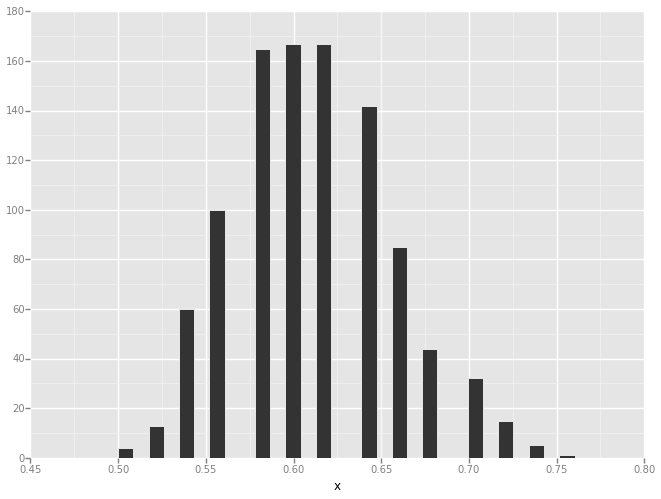

<ggplot: (283946089)>

In [240]:
results_l = []
i = 0

while i < 1000:
    results = model(flowers)[0]
    results_l.append(results)
    i+=1

qplot(results_l)

After 1000 runs we can start to get a pretty good picture of the potential variation. Generally, we will let our machine learning package handle this type of thing for us though.

# K-Nearest Neighbor Classifier

Let's get into more complex classifiers. We will also be using a new agriculturally based dataset called <a href='http://archive.ics.uci.edu/ml/datasets/seeds#'>Seeds</a>, which consists of measurements of wheat seeds.

Pandas can load the data right from a url. Note that we had to exclude come rows due to data errors.

In [301]:
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt"

df = pd.read_csv(url, sep = "\t", header=False, error_bad_lines=False,
names = ['area','perim','compact','length','width','asymc','length_groove', 'wheat_type'])

Skipping line 8: expected 8 fields, saw 10
Skipping line 36: expected 8 fields, saw 10
Skipping line 61: expected 8 fields, saw 9
Skipping line 69: expected 8 fields, saw 9
Skipping line 107: expected 8 fields, saw 9
Skipping line 136: expected 8 fields, saw 9
Skipping line 170: expected 8 fields, saw 9
Skipping line 171: expected 8 fields, saw 9
Skipping line 173: expected 8 fields, saw 9
Skipping line 202: expected 8 fields, saw 9
Skipping line 204: expected 8 fields, saw 9



In [302]:
df.describe()

,area,perim,compact,length,width,asymc,length_groove,wheat_type
count,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000
mean,14.917020,14.594596,0.870810,5.642545,3.265298,3.706683,5.421667,2.000000
std,2.927276,1.313651,0.023379,0.444635,0.379266,1.471047,0.493759,0.812341
min,10.590000,12.410000,0.808100,4.899000,2.630000,0.765100,4.519000,1.000000
25%,12.315000,13.470000,0.856900,5.267000,2.953750,2.600250,5.046000,1.000000
50%,14.405000,14.360000,0.873450,5.541000,3.243500,3.634500,5.229500,2.000000
75%,17.502500,15.827500,0.886900,6.004000,3.565250,4.812000,5.879000,3.000000
max,21.180000,17.250000,0.918300,6.675000,4.033000,8.315000,6.550000,3.000000


As we can see, this dataset is a bit more complex than `iris`. We now have 7 features and three types of wheat: `Canadian`, `Koma`, and `Rosa`.

Of these 7 features, one of them, **compactness**, is not technically a new variable, but a function of two features, `perimeter` and `area`. It is common practise, and often very useful to derive new combined features like this. It usually termed **feature engineering**. 

The target for a good feature in any type of machine learning is that it is both varies with what matters and is invariate with what does not. Compactness in wheat varies with shape, and not size, which is a better predictor of wheat type. The best tool for creating good features is strong intuition and knowledge of the data. Generally, for most common sources of data, there are already a set of preferred and potential features generated by previous literature.

**All in all, simpler is better.**

## Definition:

K-nearest neighbour (KNN) is a supervised learning algorithm for classification or regression. One of the most common usages is for personalization tasks. To make an accurate personalized offer to a customer, you could use KNN to find similar customers and base your offer from their previous purchase behaviour.

<hr>
KNN is utilized when class labels are known for a dataset and you want to predict the class of a new data point. The predicted class will be based on the known classes NN. We are simply trying to find the class that is most similar to the new data point you are trying to predict.

For example: what class should the green circle belong to? Blue or Red?

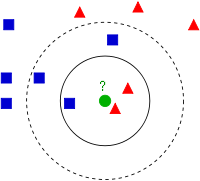

In [347]:
from IPython.core.display import Image
Image("http://upload.wikimedia.org/wikipedia/commons/thumb/e/e7/KnnClassification.svg/200px-KnnClassification.svg.png")

## Choosing the right value of k

It turns out that  the correct value for `k` is very important. Generally, it is best to start out with an odd number, since this avoids situations where your classifier "ties" as a result of having the same number of votes for two or more classes. Like before in the IPython notebook for <a href = "">Curve Fitting (add link)</a>, we are vulnerable to <a href="http://en.wikipedia.org/wiki/Overfitting">overfitting</a>. To remedy this we can examine a plot of accuracy over increasing `k`. The optimal `k` is not often the highest `k` values, but rather the `k` at which improvements in accuracy begin to slow down dramatically.

Let's see what I mean here, and grab a dataset with many more values. Here we will use a few features of the wine ingredients to predict if it is high quality or not.

In [2]:
from sklearn.neighbors import KNeighborsClassifier

df = pd.read_csv("https://s3.amazonaws.com/demo-datasets/wine.csv")

In [351]:
# Take a look at the data
df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color,is_red,high_quality
0,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,red,1,0
1,7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5,red,1,0
2,7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5,red,1,0
3,11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6,red,1,0
4,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,red,1,0


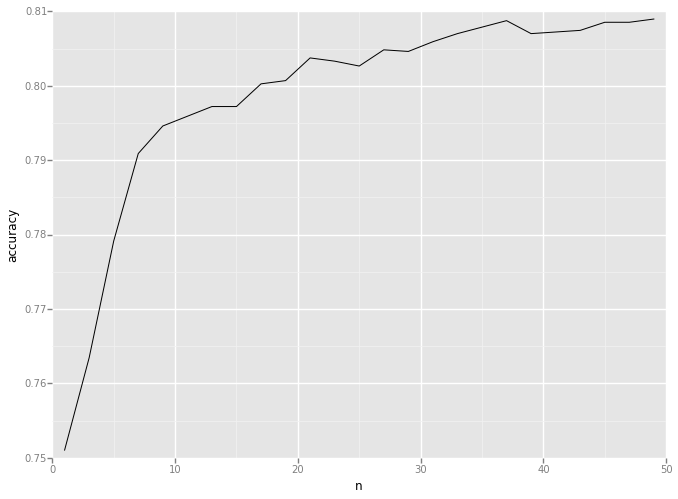

<ggplot: (280700665)>

In [4]:
def best_k(df, features):
    # Randomly sample 70% training data, 30% testing data
    test_idx = np.random.uniform(0,1, len(df)) <= 0.3
    train = df[test_idx==True]
    test = df[test_idx==False]

    # List of features we want to test
    features = ['density', 'sulphates', 'residual_sugar']
    results = []
    for n in range(1,51,2):
        clf = KNeighborsClassifier(n_neighbors=n)
        clf.fit(train[features], train['high_quality'])
        preds = clf.predict(test[features])
        # If True = 1, if False = 0
        accuracy = np.where(preds==test['high_quality'], 1, 0).sum() / float(len(test))

        results.append([n, accuracy])

    results = pd.DataFrame(results, columns = ['n', 'accuracy'])
    
    plot = ggplot(results, aes("n", "accuracy"))+geom_line()
    return [results, test, train, plot]

# Features we want to use
features = ['density', 'sulphates', 'residual_sugar']

optimal_k_model = best_k(df, features)
optimal_k_model[3]

As we can see from this plot, the `k` with the best accuracy can be found at around **37**, however, accuracy doesn't really improve much after `k = ~9`. Most of the trend is caught at this `k` level, and beyond that we risk overfitting. Again, there are more sophisticated ways of doing this, but that will be discussed later.

In general, a larger `k` suppresses the effects of the noise, but makes the classification boundaries less distinct, which is really our actual goal.
<hr>

## Distance between points

Remember, KNN classification utilizes the idea that each observation is represented by it's features in N-dimensional space. Therefore we can compute the distance between the observations (in several ways). The second most important parameter in KNN models is how you choose to calculate the distance between the points.

The most common distance functions are `uniform`, which weights everything equally, and `distance`, which weights the points based on the inverse distance between them. There are many other ways to do this as well. 

Let's compare the results of all three of these types of weights:

In [5]:
def KNN(train_data, test_data, k):
    results = []

    for w in ['uniform','distance', lambda x: np.log(x)]:
        # Run with 9 neighbors
        clf = KNeighborsClassifier(k, weights=w)
        w = str(w)
        clf.fit(train_data[features], train_data['high_quality'])
        prediction = clf.predict(test_data[features])
        accuracy = np.where(prediction==test_data['high_quality'], 1, 0).sum() / float(len(test_data))

        results.append([w, accuracy])

    results = pd.DataFrame(results, columns = ['weight_method', 'accuracy'])

    return results

train = optimal_k_model[2]
test = optimal_k_model[1]

KNN(train, test, 9)

,weight_method,accuracy
0,uniform,0.794598
1,distance,0.798301
2,<function <lambda> at 0x10bee7500>,0.809192


Pretty slick. Though ideally, we would select the weighting scheme based on some intuition about our data. Should there be more feature influence at shorter distances? When it doubt, inverse distance is a good place to start, because it helps avoid problems of "majority voting" where one class dominates the data.

## Standardization

You may have noticed something about these above examples. We have been mixing up our units (this is bad) by summing up volumes, weights, densities and concentrations.

Let's take a look at our data again to understand whats happening here.

In [359]:
df[features].describe()

,density,sulphates,residual_sugar
count,6497.000000,6497.000000,6497.000000
mean,0.994697,0.531268,5.443235
std,0.002999,0.148806,4.757804
min,0.987110,0.220000,0.600000
25%,0.992340,0.430000,1.800000
50%,0.994890,0.510000,3.000000
75%,0.996990,0.600000,8.100000
max,1.038980,2.000000,65.800000


If we are computing distance between these features in 3D space, we can see that small changes in density and sulphates, will equate to large changes in residual sugar content. This, in essence, makes residual sugar seem more important if we are treating the units equally, since the numbers are simply larger.

The solution is **standardization**, commonly referred to as **normalization** in statistics, whereby we adjust features on different scales to a single common scale. There are also various types of normalization, <a href="http://en.wikipedia.org/wiki/Normalization_(statistics)">see here</a>.

A common technique for normalizing **Z-score** (standard-score) values, which measures how far away from the mean a value is in terms of units of standard deviation. To do this we subtract the mean of each feature, then scale it by dividing it by their standard deviation. This can be implemented quite easily by hand, or also by using **`scale`** from `sklearns's` **`preprocessing`**  library.

In [54]:
from sklearn import preprocessing

# Let's standardize our data from before we put in into our functions
# Remove color column because it is text and we arnt using it anyways.
#del df['color']
tmp = preprocessing.scale(df[features])
# Re add the column names back
df_norm = pd.DataFrame(tmp, columns = list(df[features].columns.values))
# Re-join the "High Quality" feature we are trying to predict
df_norm['high_quality'] = df['high_quality'] 

# Ignore some pesky warning about color not being an integer, thanks anyways pandas.
import warnings
warnings.simplefilter(action = "ignore", category = DeprecationWarning)

df_norm.describe()

,density,sulphates,residual_sugar,high_quality
count,6.497000e+03,6.497000e+03,6.497000e+03,6497.000000
mean,2.261421e-12,-5.293322e-15,-2.203802e-15,0.196552
std,1.000077e+00,1.000077e+00,1.000077e+00,0.397421
min,-2.530192e+00,-2.091935e+00,-1.018034e+00,0.000000
25%,-7.859527e-01,-6.805919e-01,-7.657978e-01,0.000000
50%,6.448888e-02,-1.429373e-01,-5.135612e-01,0.000000
75%,7.648525e-01,4.619241e-01,5.584445e-01,0.000000
max,1.476879e+01,9.870879e+00,1.268682e+01,1.000000


Now lets repeat our KNN classification we did above with our newly standardized data and see what happens.

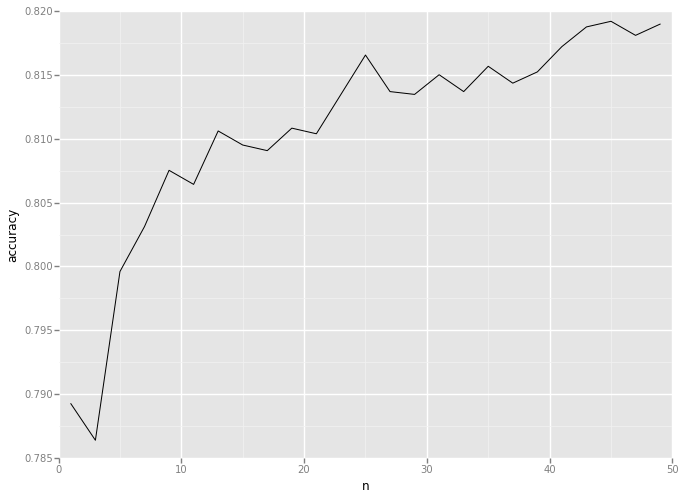

<ggplot: (280696437)>

In [58]:
# Find optimal k value
optimal_k_model = best_k(df_norm, features)
# Display the plot
optimal_k_model[3]

Looks like our `k` is still pretty close to before standardization, where a `k = ~9` appears to capture most of the trend.

In [60]:
# Fit KNN function with different weights
# Extract the data from optimal_k_model
train = optimal_k_model[2]
test = optimal_k_model[1]
KNN(train, test, 9)

,weight_method,accuracy
0,uniform,0.807540
1,distance,0.826499
2,<function <lambda> at 0x10c4dc7d0>,0.804674


Great! We can see that our model improves after standardization, this is because the distances are more accurately abstracted in 3D space.

Lets go full circle now and predict if a **new** wine will be high quality or not using our model.

In [98]:
# Sulphates, Residual sugar, and density of two new unseen wine to pass to our model
new_wine_features = [[0.66, 0.6, 0.92], [2.66, 2.1, 0.8]]

# Going through the motions again for repitition, 
# normally we would just take our model computed from above

train = optimal_k_model[2]
test = optimal_k_model[1]

clf = KNeighborsClassifier(9, "distance")
clf.fit(train[features], train['high_quality'])

print clf.get_params()
print clf.predict(new_wine_features)

{'n_neighbors': 9, 'algorithm': 'auto', 'metric': 'minkowski', 'p': 2, 'weights': 'distance', 'leaf_size': 30}
[ 0.  1.]


Where 0 is not high quality and 1 is high quality.

In [437]:
from IPython.core.display import HTML


def css_styling():
    styles = open("/users/ryankelly/desktop/custom_notebook.css", "r").read()
    return HTML(styles)
css_styling()